## TODO 
- ~~vitals graphs for patient 1~~
- ~~dendrogram in proper format (non-truncating labels)~~
- combine two figures of MDS embeddings into one in latex
    - ~~change legend to reflect patient number~~
- last sentence added into abstract "hey this is pretty promising..."
- check out mean distance over all possible pairs (I'm still not 100% convinced by this)
- check all figure captions
- ~~add reference for DTW to bib file ~~
- ~~clean up table with values/entries for all patients (pat. 1 done)~~
- ~~adjust x-axes of vital sign data to start from 0 instead of date - so "minutes from start of monitoring" ?~~
- clean up code, put on github
- if time: check average-linkage on DTW matrix to see if outliers are more obvious?


In [1]:
## Major parameters for later analysis
window = 25 # moving window
length = 180 # length of time in each segment in minutes, 6 hours = 360 minutes, 3 hours = 180 minutes

# Data import and exploration

In [81]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import pandas as pd
import csv
import io
import datetime
from sklearn import cluster
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.manifold import MDS
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
from tslearn.metrics import cdist_dtw, dtw
from tslearn.clustering import TimeSeriesKMeans

%matplotlib inline

In [3]:
filenames = [
    "001__Created_09Aug2021@1640.csv", 
    "001__Created_09Aug2021@1650.csv", 
    "002__Created_12Aug2021@1627.csv",
    "003__Created_12Aug2021@1634.csv",
    "004__Created_12Aug2021@1639.csv",
    "004__Created_12Aug2021@1642.csv",
    "005__Created_12Aug2021@1647.csv",
    "006__Created_12Aug2021@1649.csv",
    "007__Created_12Aug2021@1655.csv",
    "008__Created_12Aug2021@1700.csv"
]

In [4]:
dfs_raw = [] # we won't change this - for raw data comparison
for file in filenames:
    f = pd.read_csv(file, sep=',', header=0, index_col=0)
    dfs_raw.append(f)

In [5]:
dfs_raw[0].head(15)

,Lifetouch Heart Rate,Lifetouch Respiration Rate,Lifetouch Patient Orientation,Lifetemp Temperature,Oximeter SpO2,Oximeter Pulse,Early Warning Score,Early Warning Max
Timestamp (GMT Standard Time),,,,,,,,
12/10/2020 17:20:00,NaN,NaN,Upright,NaN,NaN,NaN,NaN,NaN
12/10/2020 17:21:00,61442.0,61442.0,Right Side,31.0,95.0,99.0,NaN,NaN
12/10/2020 17:22:00,61441.0,61441.0,Right Side,61445.0,NaN,NaN,NaN,NaN
12/10/2020 17:23:00,61446.0,61446.0,Back,61445.0,NaN,NaN,NaN,NaN
12/10/2020 17:24:00,61442.0,61442.0,Upright,31.8,NaN,NaN,NaN,NaN
12/10/2020 17:25:00,87.0,18.0,Upright,32.3,NaN,NaN,NaN,NaN
12/10/2020 17:26:00,85.0,17.0,Upright,32.6,NaN,NaN,NaN,NaN
12/10/2020 17:27:00,89.0,17.0,Upright,32.7,NaN,NaN,NaN,NaN
12/10/2020 17:28:00,89.0,16.0,Upright,32.7,NaN,NaN,NaN,NaN


In [6]:
for df in dfs_raw:
    print(df.shape)

(1464, 8)
(40361, 8)
(1329, 8)
(33133, 8)
(10254, 8)
(41818, 8)
(30317, 8)
(22861, 8)
(49073, 8)
(50096, 8)


In [7]:
# NaN remaining values that are clearly error codes, in this case greater than 500
for df in dfs_raw:
    df.where(df[['Lifetouch Heart Rate', 'Lifetouch Respiration Rate', 'Lifetemp Temperature']] < 500, np.NaN, inplace=True)
dfs_raw[0].head(15)   

,Lifetouch Heart Rate,Lifetouch Respiration Rate,Lifetouch Patient Orientation,Lifetemp Temperature,Oximeter SpO2,Oximeter Pulse,Early Warning Score,Early Warning Max
Timestamp (GMT Standard Time),,,,,,,,
12/10/2020 17:20:00,NaN,NaN,Upright,NaN,NaN,NaN,NaN,NaN
12/10/2020 17:21:00,NaN,NaN,Right Side,31.0,95.0,99.0,NaN,NaN
12/10/2020 17:22:00,NaN,NaN,Right Side,NaN,NaN,NaN,NaN,NaN
12/10/2020 17:23:00,NaN,NaN,Back,NaN,NaN,NaN,NaN,NaN
12/10/2020 17:24:00,NaN,NaN,Upright,31.8,NaN,NaN,NaN,NaN
12/10/2020 17:25:00,87.0,18.0,Upright,32.3,NaN,NaN,NaN,NaN
12/10/2020 17:26:00,85.0,17.0,Upright,32.6,NaN,NaN,NaN,NaN
12/10/2020 17:27:00,89.0,17.0,Upright,32.7,NaN,NaN,NaN,NaN
12/10/2020 17:28:00,89.0,16.0,Upright,32.7,NaN,NaN,NaN,NaN


## How much non-NaN data do we have?

In [8]:
total_readings = 0
cumulative_reading_time = 0
min_recording_time = 999
max_recording_time = 0
patient_list = [1, 1, 2, 3, 4, 4, 5, 6, 7, 8]

for j, df in enumerate(dfs_raw):
    print(f"\nPatient {patient_list[j]} (file {j})")
    print(f"Total length: {df.shape[0]}")
    print(f"Total entries with at least one reading: {df.dropna(how='all').shape[0]}, "
          f"equivalent to {df.dropna(how='all').shape[0]/60:.2f} hours")
    
    total_readings += df.dropna(how='all').shape[0] # only drop row if it has zero readings 
    reading_time = df.index.get_loc(df.notna()[::-1].idxmax().max()) - df.index.get_loc(df.notna().idxmax().min()) + 1
        # last entry index - first entry index
    if reading_time < min_recording_time:
        min_recording_time = reading_time 
    if reading_time > max_recording_time:
        max_recording_time = reading_time
    print(f"Length of time between first and last reading: {reading_time/60:.2f} hours")
    cumulative_reading_time += reading_time
    
    # iterate over columns (in order of table in paper)
    for i in ['Lifetouch Heart Rate', 'Lifetouch Respiration Rate', 'Lifetemp Temperature', 'Oximeter SpO2', 'Oximeter Pulse']:
        first_idx = df.notna().idxmax()[i]
        last_idx = df.notna()[::-1].idxmax()[i]
        print(f"   {i} hours: {df.count()[i]/60:.2f}")

print(f"\n Total readings: {total_readings/60:.2f} over {cumulative_reading_time/60:.2f} hours " + 
     f"(Range: {min_recording_time:.0f} minutes to {max_recording_time/60:.2f} hours.)")



Patient 1 (file 0)
Total length: 1464
Total entries with at least one reading: 97, equivalent to 1.62 hours
Length of time between first and last reading: 24.40 hours
   Lifetouch Heart Rate hours: 0.62
   Lifetouch Respiration Rate hours: 0.62
   Lifetemp Temperature hours: 1.57
   Oximeter SpO2 hours: 0.02
   Oximeter Pulse hours: 0.02

Patient 1 (file 1)
Total length: 40361
Total entries with at least one reading: 11287, equivalent to 188.12 hours
Length of time between first and last reading: 188.37 hours
   Lifetouch Heart Rate hours: 145.57
   Lifetouch Respiration Rate hours: 145.57
   Lifetemp Temperature hours: 152.78
   Oximeter SpO2 hours: 10.38
   Oximeter Pulse hours: 10.38

Patient 2 (file 2)
Total length: 1329
Total entries with at least one reading: 140, equivalent to 2.33 hours
Length of time between first and last reading: 2.33 hours
   Lifetouch Heart Rate hours: 2.30
   Lifetouch Respiration Rate hours: 2.30
   Lifetemp Temperature hours: 2.32
   Oximeter SpO2 hour

In [9]:
# patient 1 descriptive stats combined
print(f"\nPatient 1 (files 1 and 2)")
df1_merged = dfs_raw[0].append(dfs_raw[1])
print(f"Total length: {df1_merged.shape[0]}")
print(f"Total entries with at least one reading: {df1_merged.dropna(how='all').shape[0]}, "
      f"equivalent to {df1_merged.dropna(how='all').shape[0]/60:.2f} hours")

reading_time = (df1_merged.index.get_loc(df1_merged.notna()[::-1].idxmax().max()) - 
        df1_merged.index.get_loc(df1_merged.notna().idxmax().min()) + 1)
print(f"Length of time between first and last reading: {reading_time/60:.2f} hours")
for i in ['Lifetouch Heart Rate', 'Lifetouch Respiration Rate', 'Lifetemp Temperature', 'Oximeter SpO2', 'Oximeter Pulse']:
        first_idx = df1_merged.notna().idxmax()[i]
        last_idx = df1_merged.notna()[::-1].idxmax()[i]
        print(f"   {i} hours: {df1_merged.count()[i]/60:.2f}")

# patient 4  descriptive stats combined
print(f"\nPatient 4 (files 4 and 5)")
df4_merged = dfs_raw[4].append(dfs_raw[5])
print(f"Total length: {df4_merged.shape[0]}")
print(f"Total entries with at least one reading: {df4_merged.dropna(how='all').shape[0]}, "
      f"equivalent to {df4_merged.dropna(how='all').shape[0]/60:.2f} hours")

reading_time = (df4_merged.index.get_loc(df4_merged.notna()[::-1].idxmax().max()) - 
        df4_merged.index.get_loc(df4_merged.notna().idxmax().min()) + 1)
print(f"Length of time between first and last reading: {reading_time/60:.2f} hours")
for i in ['Lifetouch Heart Rate', 'Lifetouch Respiration Rate', 'Lifetemp Temperature', 'Oximeter SpO2', 'Oximeter Pulse']:
        first_idx = df4_merged.notna().idxmax()[i]
        last_idx = df4_merged.notna()[::-1].idxmax()[i]
        print(f"   {i} hours: {df4_merged.count()[i]/60:.2f}")


Patient 1 (files 1 and 2)
Total length: 41825
Total entries with at least one reading: 11384, equivalent to 189.73 hours
Length of time between first and last reading: 212.78 hours
   Lifetouch Heart Rate hours: 146.18
   Lifetouch Respiration Rate hours: 146.18
   Lifetemp Temperature hours: 154.35
   Oximeter SpO2 hours: 10.40
   Oximeter Pulse hours: 10.40

Patient 4 (files 4 and 5)
Total length: 52072
Total entries with at least one reading: 21224, equivalent to 353.73 hours
Length of time between first and last reading: 335.52 hours
   Lifetouch Heart Rate hours: 300.08
   Lifetouch Respiration Rate hours: 300.08
   Lifetemp Temperature hours: 106.90
   Oximeter SpO2 hours: 1.67
   Oximeter Pulse hours: 1.67


In [10]:
# a more granular view at percentage of non-NaN values within recording intervals for each measurement
for j, df in enumerate(dfs_raw):
    print(f"\nFile {j}")
    print(f"Total length: {df.shape[0]}")
    print(f"Entries with 3 valid readings: {df.dropna().shape[0]}")
    print(f"Entries with 2 valid readings: {df[['Lifetouch Heart Rate', 'Lifetouch Respiration Rate']].dropna().shape[0]}")
    for i in range(df.shape[1]): # iterate over columns
        first_idx = df.notna().idxmax()[i]
        last_idx = df.notna()[::-1].idxmax()[i]
        print(f"   {df.columns[i]} trimmed hours: {df[first_idx:last_idx].shape[0]/60:.2f}")
        print(f"          Non-NaN values: {df.count()[i]}")
        print(f"          Percent non-NaN: {df.count()[i]/df[first_idx:last_idx].shape[0]*100:.2f}") # from trimmed
    


File 0
Total length: 1464
Entries with 3 valid readings: 0
Entries with 2 valid readings: 37
   Lifetouch Heart Rate trimmed hours: 0.62
          Non-NaN values: 37
          Percent non-NaN: 100.00
   Lifetouch Respiration Rate trimmed hours: 0.62
          Non-NaN values: 37
          Percent non-NaN: 100.00
   Lifetouch Patient Orientation trimmed hours: 1.60
          Non-NaN values: 94
          Percent non-NaN: 97.92
   Lifetemp Temperature trimmed hours: 1.60
          Non-NaN values: 94
          Percent non-NaN: 97.92
   Oximeter SpO2 trimmed hours: 0.02
          Non-NaN values: 1
          Percent non-NaN: 100.00
   Oximeter Pulse trimmed hours: 0.02
          Non-NaN values: 1
          Percent non-NaN: 100.00
   Early Warning Score trimmed hours: 24.40
          Non-NaN values: 0
          Percent non-NaN: 0.00
   Early Warning Max trimmed hours: 24.40
          Non-NaN values: 0
          Percent non-NaN: 0.00

File 1
Total length: 40361
Entries with 3 valid readings: 5

   Early Warning Max trimmed hours: 498.63
          Non-NaN values: 302
          Percent non-NaN: 1.01

File 9
Total length: 50096
Entries with 3 valid readings: 34
Entries with 2 valid readings: 9349
   Lifetouch Heart Rate trimmed hours: 161.88
          Non-NaN values: 9349
          Percent non-NaN: 96.25
   Lifetouch Respiration Rate trimmed hours: 161.88
          Non-NaN values: 9349
          Percent non-NaN: 96.25
   Lifetouch Patient Orientation trimmed hours: 161.92
          Non-NaN values: 9593
          Percent non-NaN: 98.74
   Lifetemp Temperature trimmed hours: 257.55
          Non-NaN values: 15417
          Percent non-NaN: 99.77
   Oximeter SpO2 trimmed hours: 149.03
          Non-NaN values: 47
          Percent non-NaN: 0.53
   Oximeter Pulse trimmed hours: 149.03
          Non-NaN values: 47
          Percent non-NaN: 0.53
   Early Warning Score trimmed hours: 149.03
          Non-NaN values: 36
          Percent non-NaN: 0.40
   Early Warning Max trimmed hours

### Let's get rid of some useless columns
Drop `LifetouchPatientOrientation`, `EarlyWarningScore`, `EarlyWarningMax`. (Optionally `OximeterSpO2` and `OximeterPulse` as well.) 

Ended up also removing `LifetempTemperature`, as it's so variable that it just adds noise to the data.

In [11]:
dfs_raw[1]["Lifetemp Temperature"].dropna()

Timestamp (GMT Standard Time)
14/10/2020 13:59:00    30.2
14/10/2020 14:00:00    30.7
14/10/2020 14:01:00    30.5
14/10/2020 14:02:00    30.2
14/10/2020 16:54:00    30.9
                       ... 
21/10/2020 09:24:00    31.2
21/10/2020 09:25:00    31.2
21/10/2020 09:26:00    31.2
21/10/2020 09:27:00    31.4
21/10/2020 09:28:00    30.7
Name: Lifetemp Temperature, Length: 9167, dtype: float64

Percentage of values below 34C: 20.50%


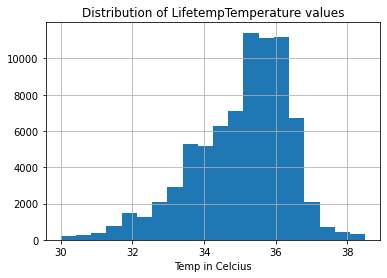

In [12]:
# let's plot the distribution of temperature data - if many values are implausible,
# we can justify excluding this measurement
temperatures = pd.concat([df["Lifetemp Temperature"] for df in dfs_raw])
temperatures.dropna(inplace=True)

# check % of values below a minimum plausible temperature
threshold = 34 
pct = temperatures.where(temperatures < threshold).count()/temperatures.count()*100
print(f"Percentage of values below {threshold}C: {pct:.2f}%")
temperatures.hist(bins=20)
plt.title('Distribution of LifetempTemperature values')
plt.xlabel('Temp in Celcius')
plt.show()

In [13]:
dfs = [] # the data we'll use for the rest of the notebook
for df in dfs_raw:
    dfs.append(df.drop([
        'Lifetouch Patient Orientation', 
        'Lifetemp Temperature',
        'Oximeter SpO2', 
        'Oximeter Pulse', 
        'Early Warning Score',
        'Early Warning Max'
    ], axis=1))

# Remaining data overview

In [14]:
j = 0
for df in dfs:
    print(f"\nFile {j}")
    print(f"Total length: {df.shape[0]}")
    for i in range(df.shape[1]): # iterate over columns
        first_idx = df.notna().idxmax()[i]
        last_idx = df.notna()[::-1].idxmax()[i]
        print(f"   {df.columns[i]} trimmed: {df[first_idx:last_idx].shape[0]}")
        print(f"          Non-NaN values: {df.count()[i]}")
        print(f"          Percent non-NaN: {df.count()[i]/df[first_idx:last_idx].shape[0]*100:.2f}") #from trimmed
    
    j+=1


File 0
Total length: 1464
   Lifetouch Heart Rate trimmed: 37
          Non-NaN values: 37
          Percent non-NaN: 100.00
   Lifetouch Respiration Rate trimmed: 37
          Non-NaN values: 37
          Percent non-NaN: 100.00

File 1
Total length: 40361
   Lifetouch Heart Rate trimmed: 9869
          Non-NaN values: 8734
          Percent non-NaN: 88.50
   Lifetouch Respiration Rate trimmed: 9869
          Non-NaN values: 8734
          Percent non-NaN: 88.50

File 2
Total length: 1329
   Lifetouch Heart Rate trimmed: 138
          Non-NaN values: 138
          Percent non-NaN: 100.00
   Lifetouch Respiration Rate trimmed: 138
          Non-NaN values: 138
          Percent non-NaN: 100.00

File 3
Total length: 33133
   Lifetouch Heart Rate trimmed: 139
          Non-NaN values: 123
          Percent non-NaN: 88.49
   Lifetouch Respiration Rate trimmed: 139
          Non-NaN values: 123
          Percent non-NaN: 88.49

File 4
Total length: 10254
   Lifetouch Heart Rate trimmed: 3

### Plot all the data for all patients

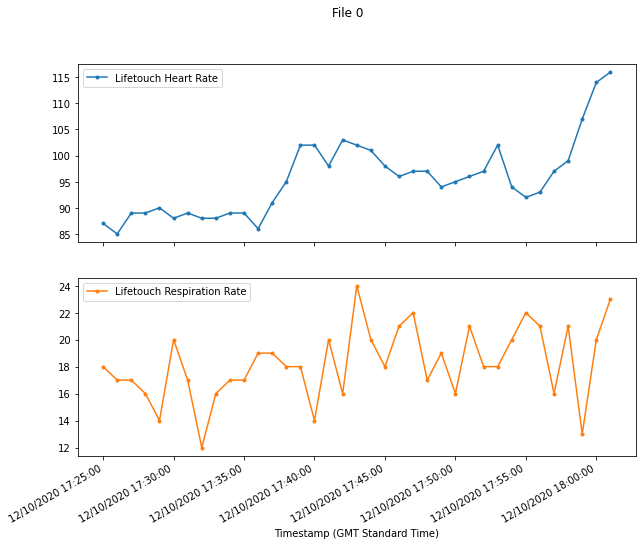

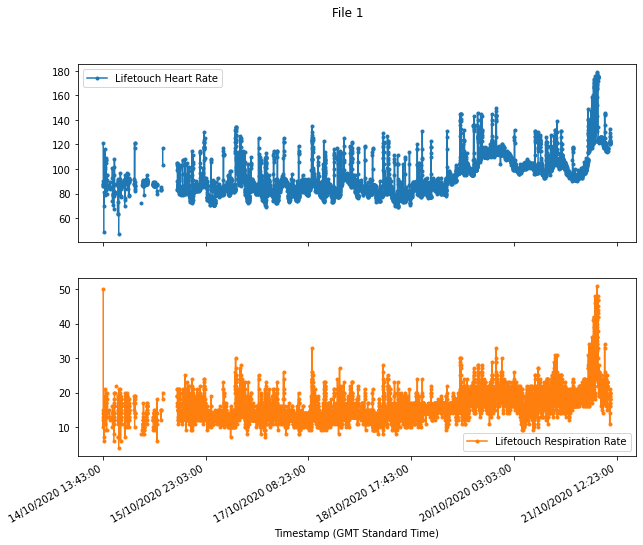

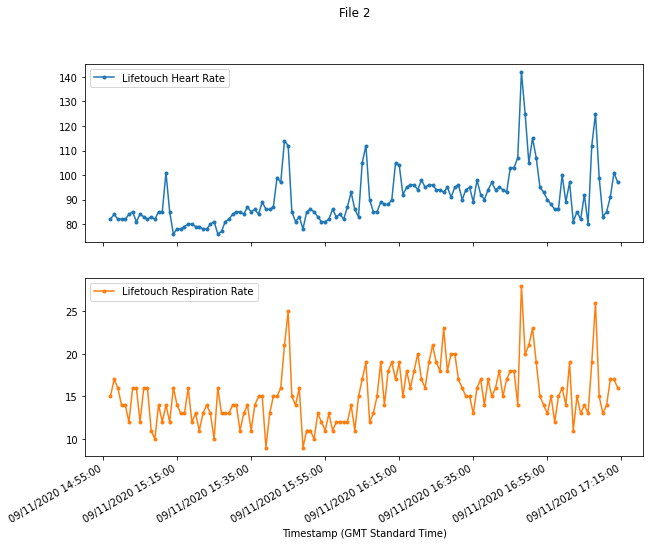

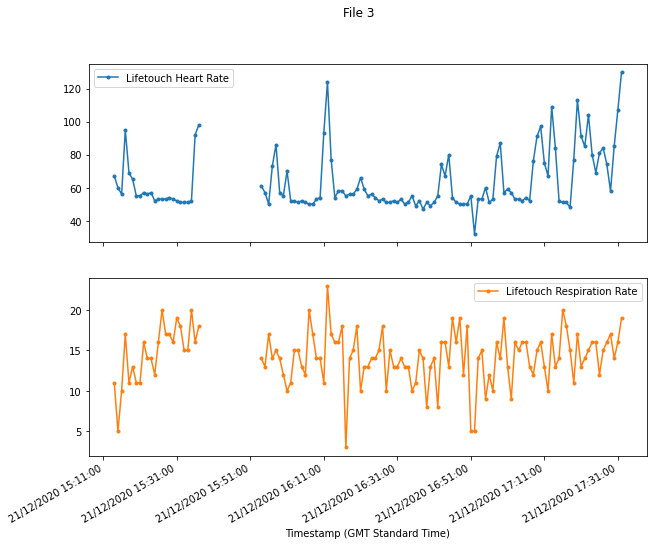

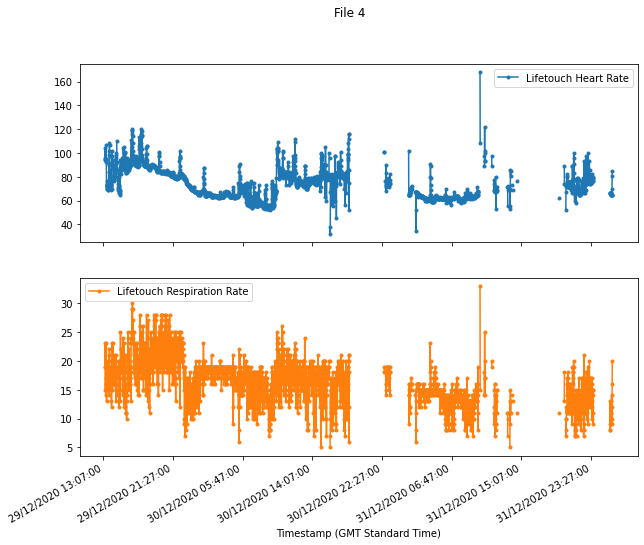

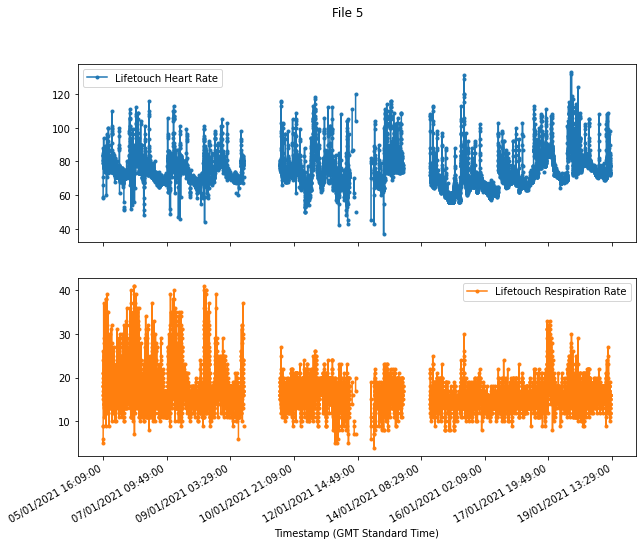

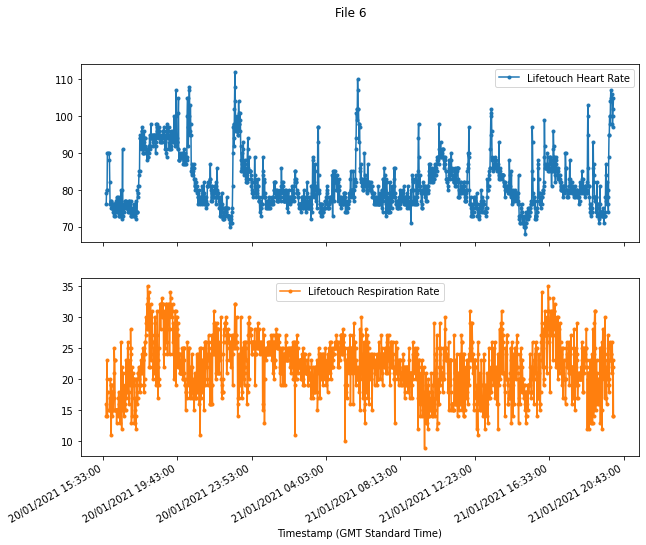

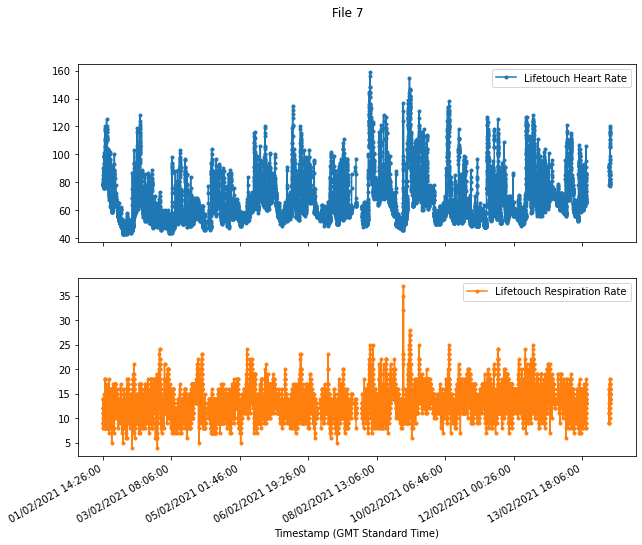

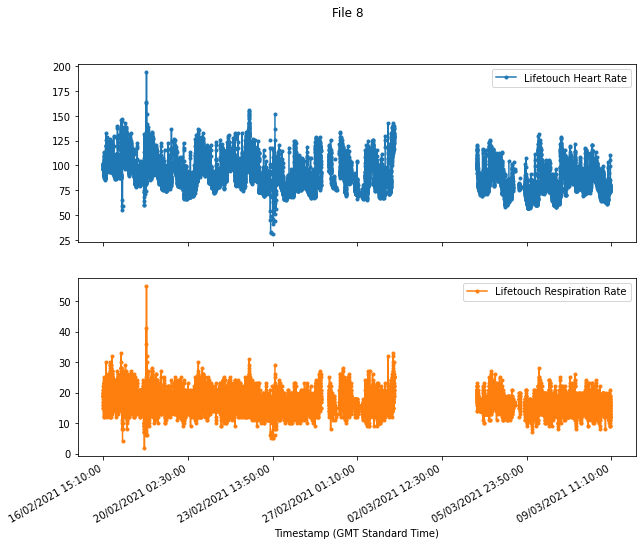

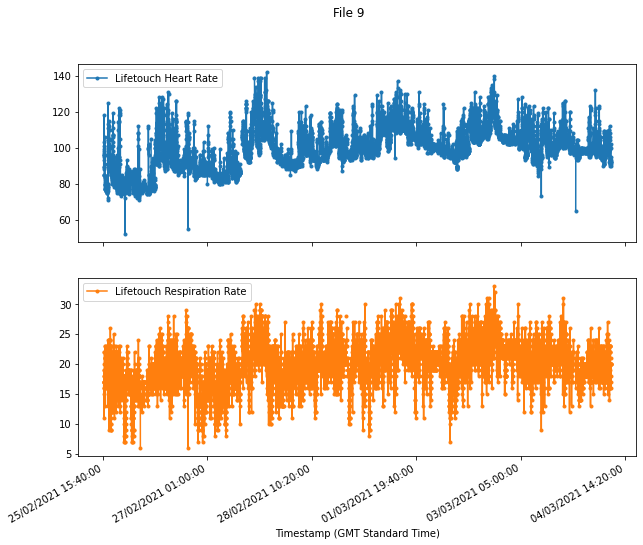

In [15]:
for i in range(len(dfs)):
    dfs[i].plot(subplots=True, style='.-', figsize=(10,8), title=("File " + str(i)))

### Plot 12 hours of data for one patient

array([<AxesSubplot:xlabel='Timestamp (GMT Standard Time)'>,
       <AxesSubplot:xlabel='Timestamp (GMT Standard Time)'>], dtype=object)

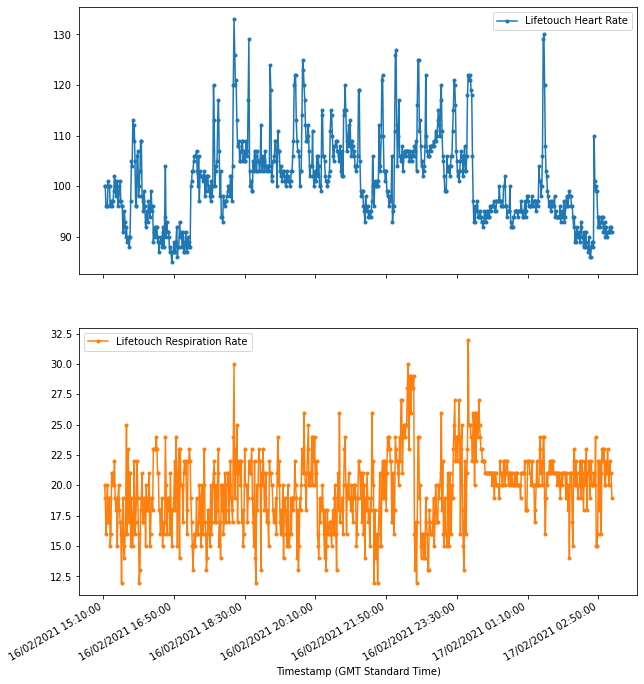

In [16]:
# starts at 0700, 12 hours should be 1900
# by location 12*60 = 720
# possible to interpolate idx 1 and 8 files
# splines?
dfs[8].iloc[:720].plot(subplots=True, style='.-', figsize=(10,12))

In [17]:
# dfs[8]['LifetouchHeartRate'].plot(style='.-')

# Analysis

### Normalize the data

In [18]:
normalized_dfs = []
for df in dfs:
    normalized_dfs.append((df - df.mean(skipna=True))/df.std(skipna=True))

#patient1_1_normalized = (dfs[0] - dfs[0].mean(skipna=True))/dfs[0].std(skipna=True)
normalized_dfs[0].head(10)

,Lifetouch Heart Rate,Lifetouch Respiration Rate
Timestamp (GMT Standard Time),,
12/10/2020 17:20:00,NaN,NaN
12/10/2020 17:21:00,NaN,NaN
12/10/2020 17:22:00,NaN,NaN
12/10/2020 17:23:00,NaN,NaN
12/10/2020 17:24:00,NaN,NaN
12/10/2020 17:25:00,-1.172154,-0.089016
12/10/2020 17:26:00,-1.446646,-0.454971
12/10/2020 17:27:00,-0.897662,-0.454971
12/10/2020 17:28:00,-0.897662,-0.820926


### Smooth the data

Median filter (what window size is good here?)

Using https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rolling.html

In [19]:
# window is set at top but can also set here...
# window=25
use_center=False
smoothed_dfs = []
# places in rightmost position in window, alternately can set center=True

for df in normalized_dfs:
    smoothed_dfs.append(df.rolling(window=window, center=use_center).median())
smoothed_dfs[0].head(5)

,Lifetouch Heart Rate,Lifetouch Respiration Rate
Timestamp (GMT Standard Time),,
12/10/2020 17:20:00,NaN,NaN
12/10/2020 17:21:00,NaN,NaN
12/10/2020 17:22:00,NaN,NaN
12/10/2020 17:23:00,NaN,NaN
12/10/2020 17:24:00,NaN,NaN


In [20]:
# compare to similar plots above
# smoothed_dfs[8].iloc[:720].plot(subplots=True, style='.-', figsize=(10,12))

### Partition the data
Split the patient's data into equal size segments. I do this by taking the floor of the number of entries divided by 720 (minutes in 12 hours), so that each partition is $12 \leq t < 13$ hours long. This ensures the splits are of equal length for each patient, but if we want them all to be exactly 12 hours long (with the final partition holding the remainder), I need to change this method.

Another thing to consider: if there are large chunks of NaNs, should we simply exclude these segments before partitioning? What's considered a segment of missing data? Is there a way to determine this algorithmically, or should we just look at the data for each patient?

In [21]:
for df in smoothed_dfs:
    print(df.shape)

(1464, 2)
(40361, 2)
(1329, 2)
(33133, 2)
(10254, 2)
(41818, 2)
(30317, 2)
(22861, 2)
(49073, 2)
(50096, 2)


In [22]:
# Remove leading and trailing NaNs in all columns 
# basically, find the earliest timestep with an entry, and remove 
# all timesteps before then from the array.

for i in range(len(smoothed_dfs)):
    first_entry = smoothed_dfs[i].notna().idxmax().min()
    last_entry = smoothed_dfs[i].notna()[::-1].idxmax().max()
    smoothed_dfs[i] = smoothed_dfs[i].loc[first_entry:last_entry]

array([<AxesSubplot:xlabel='Timestamp (GMT Standard Time)'>,
       <AxesSubplot:xlabel='Timestamp (GMT Standard Time)'>], dtype=object)

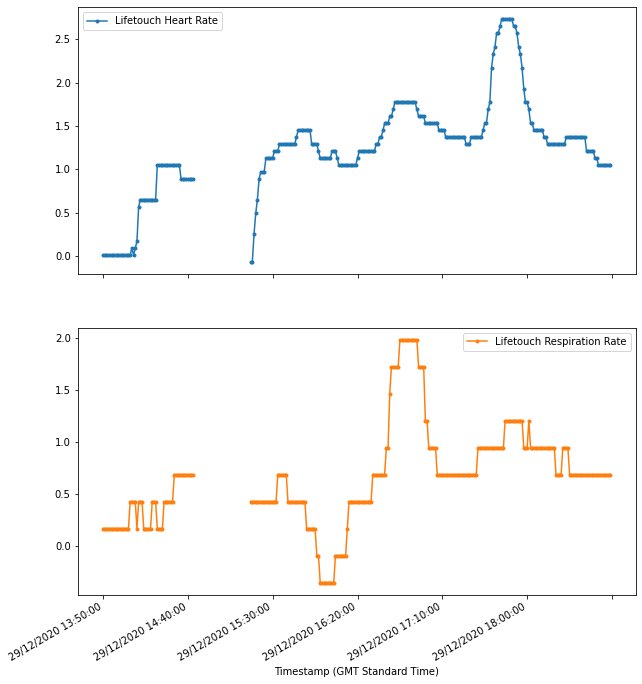

In [23]:
smoothed_dfs[4].iloc[:300].plot(subplots=True, style='.-', figsize=(10,12))

In [24]:
data = smoothed_dfs[4]
first_idx = data.notna().idxmax()
last_idx = data.notna()[::-1].idxmax()
print(" ----- First entries: ------")
print(first_idx)
print("------ Last entries: -------")
print(last_idx)
print("")

for i in range(data.shape[1]):
    print(f"{data.columns[i]} trimmed: {data[first_idx[i]:last_idx[i]].shape[0]}")
    print(f"Non-NaN values: {data.count()[i]}")
# print(f"          Percent non-NaN: {df.count()[i]/df[first_idx:last_idx].shape[0]*100:.2f}") #from trimmed

print("")
print(f"Entries with {smoothed_dfs[0].shape[1]} valid readings: {data.dropna().shape[0]}")

 ----- First entries: ------
Lifetouch Heart Rate          29/12/2020 13:50:00
Lifetouch Respiration Rate    29/12/2020 13:50:00
dtype: object
------ Last entries: -------
Lifetouch Heart Rate          31/12/2020 23:41:00
Lifetouch Respiration Rate    31/12/2020 23:41:00
dtype: object

Lifetouch Heart Rate trimmed: 3472
Non-NaN values: 2216
Lifetouch Respiration Rate trimmed: 3472
Non-NaN values: 2216

Entries with 2 valid readings: 2216


In [25]:
def find_valid_intervals(data): 
    # Find rows with any NaN values, create as mask
    # add leading and trailing buffer so we can compare to the next row sequentially
    mask = np.concatenate(( [True], data.isna().any(axis=1).to_numpy(), [True] ))

    # get start and stop limits, reshape them into array of (start, stop) pairs
    ss = np.flatnonzero(mask[1:] != mask[:-1]).reshape(-1,2) 
    return(ss)

In [26]:
# verify above method works on all dfs compared to dropna() count
for idx, df in enumerate(smoothed_dfs):
    print(f"--------- File {idx} ---------")
    ss = find_valid_intervals(df)
    print(f"Longest interval: {(ss[:,1] - ss[:,0]).max()}")
    print(f"Sum of valid entries across all intervals: {(ss[:,1] - ss[:,0]).sum()}")
    print(f"Entries with {smoothed_dfs[0].shape[1]} valid readings: {df.dropna().shape[0]}")

--------- File 0 ---------
Longest interval: 13
Sum of valid entries across all intervals: 13
Entries with 2 valid readings: 13
--------- File 1 ---------
Longest interval: 3225
Sum of valid entries across all intervals: 8343
Entries with 2 valid readings: 8343
--------- File 2 ---------
Longest interval: 114
Sum of valid entries across all intervals: 114
Entries with 2 valid readings: 114
--------- File 3 ---------
Longest interval: 75
Sum of valid entries across all intervals: 75
Entries with 2 valid readings: 75
--------- File 4 ---------
Longest interval: 1492
Sum of valid entries across all intervals: 2216
Entries with 2 valid readings: 2216
--------- File 5 ---------
Longest interval: 2609
Sum of valid entries across all intervals: 13270
Entries with 2 valid readings: 13270
--------- File 6 ---------
Longest interval: 1672
Sum of valid entries across all intervals: 1672
Entries with 2 valid readings: 1672
--------- File 7 ---------
Longest interval: 2681
Sum of valid entries acro

In [27]:
# length parameter is length of interval in minutes
def split_into_intervals(data, length=720, idx=None):
    # initialize list into which we'll put the split arrays
    segments = [] 
    # and maybe a good idea to return the file index, start and stop indices
    metadata = []
    metadata_pts = []
    patient_list = [1, 1, 2, 3, 4, 4, 5, 6, 7, 8]
    
    # Find rows with any NaN values, create as mask
    # add leading and trailing buffer so we can compare to the next row sequentially
    mask = np.concatenate(( [True], data.isna().any(axis=1).to_numpy(), [True] ))

    # get start and stop limits, reshape them into array of (start, stop) pairs
    ss = np.flatnonzero(mask[1:] != mask[:-1]).reshape(-1,2)
    # mask to get contiguous data only greater in length than length parameter
    ss = ss[(ss[:,1] - ss[:,0]) > length]
    # find how many len(length) segments are in each contiguous block of data
    nb_splits = (ss[:,1] - ss[:,0])//length
    
    # finally, we can get our start, stop, nb_splits tuples and use np.split to
    # return a list of equal size arrays of our desired length
    starts = ss[:,0]
    ends = starts + nb_splits*length
    for start, end, nb_splits in zip(starts,ends,nb_splits):
        # Difference between append and extend here is how they're added to the 
        # list. Extend "flattens" the resulting list so we don't end up with extra
        # dimentions, but also we can't easily tell which original file the data 
        # belonged to, which is why I've included metadata. 
        segments.extend( np.split(data.to_numpy()[start:end],nb_splits) )
        for split in range(nb_splits):
            metadata.append( ("File " + str(idx), start+split*length, start+(split+1)*length) )
            metadata_pts.append( ("Patient " + str(patient_list[idx]), start+split*length, start+(split+1)*length) )
    
    return(segments, metadata, metadata_pts)
    

In [28]:
# length is set at top
# length = 360
data = []
metadata = []
metadata_pts = []
for idx, df in enumerate(smoothed_dfs):
    segments, mdata, mdata_pts = split_into_intervals(df, length=length, idx=idx)
    if mdata != []: # if no contiguous samples long enough, both lists are empty
        data.extend(segments)
        metadata.extend(mdata)
        metadata_pts.extend(mdata_pts)
metadata_pts

[('Patient 1', 1406, 1586),
 ('Patient 1', 1586, 1766),
 ('Patient 1', 1766, 1946),
 ('Patient 1', 1946, 2126),
 ('Patient 1', 2126, 2306),
 ('Patient 1', 2306, 2486),
 ('Patient 1', 2486, 2666),
 ('Patient 1', 2666, 2846),
 ('Patient 1', 2846, 3026),
 ('Patient 1', 3026, 3206),
 ('Patient 1', 3206, 3386),
 ('Patient 1', 3386, 3566),
 ('Patient 1', 3628, 3808),
 ('Patient 1', 3808, 3988),
 ('Patient 1', 3988, 4168),
 ('Patient 1', 4168, 4348),
 ('Patient 1', 4348, 4528),
 ('Patient 1', 4528, 4708),
 ('Patient 1', 4863, 5043),
 ('Patient 1', 5043, 5223),
 ('Patient 1', 5223, 5403),
 ('Patient 1', 5403, 5583),
 ('Patient 1', 5583, 5763),
 ('Patient 1', 5763, 5943),
 ('Patient 1', 5943, 6123),
 ('Patient 1', 6123, 6303),
 ('Patient 1', 6303, 6483),
 ('Patient 1', 6532, 6712),
 ('Patient 1', 6712, 6892),
 ('Patient 1', 6892, 7072),
 ('Patient 1', 7072, 7252),
 ('Patient 1', 7252, 7432),
 ('Patient 1', 7432, 7612),
 ('Patient 1', 7612, 7792),
 ('Patient 1', 7792, 7972),
 ('Patient 1', 7972,

In [83]:
# list of metadata with just the patient number

source_file_list = []
for md in metadata_pts:
    source_file_list.append(int(md[0][-1])) # take the first element in tuple ("file x"), keep only number

### Flatten the data for sklearn
What dataformat do the clustering algorithms need?
##### Distance matrix:
`shape( n_samples_x, n_features )`
##### k-means:
`shape( n_samples, n_features )`

To deal with both of these, we can simply flatten the 720x3 matrix to be a 2160x1 array, so long as it is done consistently for all samples.

In [84]:
# first let's do the sklearn format 
# take all the processed data, flatten each array, and add to a numpy array 
X = np.empty((len(data), length*smoothed_dfs[0].shape[1]))
for i, seg in enumerate(data):
    X[i] = np.ravel(seg)
X

array([[-0.49577431, -0.02738096, -0.49577431, ..., -0.02738096,
        -0.43034034, -0.02738096],
       [-0.36490637, -0.02738096, -0.29947241, ..., -0.02738096,
        -0.62664224, -0.26581098],
       [-0.62664224, -0.26581098, -0.62664224, ..., -0.74267102,
        -0.36490637, -0.74267102],
       ...,
       [-0.31221694, -0.04331389, -0.31221694, ..., -0.33276461,
        -0.12643479, -0.33276461],
       [-0.12643479, -0.33276461, -0.12643479, ..., -0.33276461,
         0.05934735, -0.04331389],
       [ 0.05934735, -0.33276461,  0.05934735, ..., -0.62221533,
        -0.40510801, -0.62221533]])

## Find the euclidean distance matrix 
Returns matrix of euclidean distances between each segment, i.e. the sum of distance between all three observations over all timesteps:

$$ \sqrt{(A_{00}-B_{00})^2 + (A_{01}-B_{01})^2 + (A_{02}-B_{02})^2 + (A_{10}-B_{10})^2 + \dots +  (A_{i2}-B_{i2})^2} $$

for size $i \times 3$ matrices $\mathbf{A}, \mathbf{B}$.

In [85]:
euc_dist_matrix = euclidean_distances(X)
euc_dist_matrix

array([[ 0.        ,  6.04244304,  9.45540152, ...,  8.47129398,
        10.15403784,  9.27213925],
       [ 6.04244304,  0.        ,  9.02952007, ..., 10.72590256,
        10.88371116,  9.85911571],
       [ 9.45540152,  9.02952007,  0.        , ...,  9.05493205,
         8.38045149,  8.6706475 ],
       ...,
       [ 8.47129398, 10.72590256,  9.05493205, ...,  0.        ,
         6.39289549,  7.41185485],
       [10.15403784, 10.88371116,  8.38045149, ...,  6.39289549,
         0.        ,  5.96763707],
       [ 9.27213925,  9.85911571,  8.6706475 , ...,  7.41185485,
         5.96763707,  0.        ]])

## Hierarchical clustering with average-linkage

In [86]:
hierarchical = linkage(X, "average")
hierarchical

array([[ 23.        ,  52.        ,   3.41648172,   2.        ],
       [ 85.        , 118.        ,   3.51224376,   2.        ],
       [  5.        ,  13.        ,   3.57685815,   2.        ],
       ...,
       [302.        , 677.        ,  33.29026223, 336.        ],
       [675.        , 678.        ,  34.60870138, 340.        ],
       [ 43.        , 679.        ,  65.45753736, 341.        ]])

In [87]:
hierarchical.shape

(340, 4)

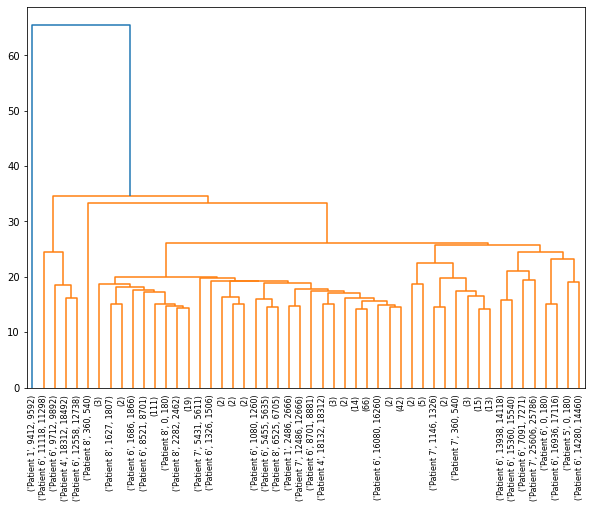

In [92]:
plt.figure(figsize=(10, 7))
dendrogram(
    hierarchical,
    orientation='top',
    truncate_mode='lastp',  # show only the last p merged clusters for readability
    p=50,  
    labels=metadata_pts,
    distance_sort='descending',
    show_leaf_counts=True)
plt.show()

### Plot an embedding of the data using the distance matrix

In [93]:
embedding = MDS(n_components=2, dissimilarity='precomputed', random_state=0)
X_transformed = embedding.fit_transform(euc_dist_matrix)

Text(0.5, 1.0, 'MDS embedding using euclidean distance matrix')

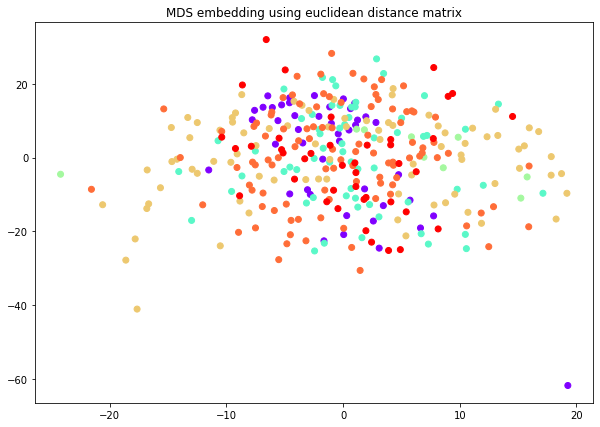

In [94]:
# colours here *should* correspond to patient?
plt.figure(figsize=(10, 7))
plt.scatter(X_transformed[:,0], X_transformed[:,1],
           c=source_file_list,
           cmap='rainbow',
           )
plt.title('MDS embedding using euclidean distance matrix')

## DTW with tslearn

Uses a pairwise formulation of distance between time series of features, that is,

$$\left( \sqrt{(A_{00}-B_{00})^2 + \cdots + (A_{i0}-B_{i0})^2} + \sqrt{(A_{01}-B_{01})^2 + \cdots + (A_{i1}-B_{i1})^2} + \sqrt{(A_{02}-B_{02})^2 + \cdots + (A_{i2}-B_{i2})^2} \right) $$

Dimentions needed:
`shape(n_ts, sz, d)` where
- `n_ts` is number of time series 
    - (in this case, `for df in dfs: n_ts += len(df)//720` = 47 as done above)
- `sz` is length of time series (number of time instants)
    - in this case, sz = 720
- `d` is dimensionality of time series
    - d = 3 here

In [95]:
# get the data into appropriate format
X_ts = np.empty((len(data), length, smoothed_dfs[0].shape[1]))
for i, seg in enumerate(data):
    X_ts[i] = seg
X_ts.shape

(341, 180, 2)

### Plot an embedding of the data using the distance matrix

In [96]:
# get the dtw distance matrix and create an embedding of it
dtw_dist_matrix = cdist_dtw(X_ts)
X_dtw_transformed = embedding.fit_transform(dtw_dist_matrix)

Text(0.5, 1.0, 'MDS embedding using DTW distance matrix')

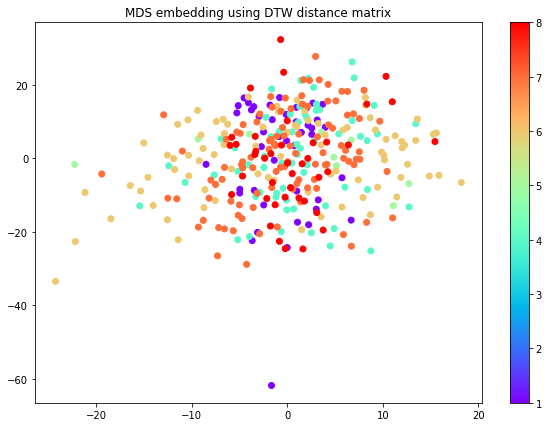

In [97]:
plt.figure(figsize=(10, 7))
plt.scatter(X_dtw_transformed[:,0], X_dtw_transformed[:,1],
           c=source_file_list,
           cmap='rainbow')
plt.colorbar()
plt.title('MDS embedding using DTW distance matrix')

### Greyscale

In [104]:
def plot_single_trajectory(labels=source_file_list, 
                           metric='euclidean', 
                           color_file=1, 
                           seed=0,): # actually not used
    """
    data: list of 2D arrays
        processed and split data
    
    metric: str, default='euclidean'
        The distance matrix to use for the embedding, can be euclidean or dtw
        
    labels: 1D array or list of len(embedding.shape[0])
        The labels corresponding to the files in the embedding
    
    color_file: int, default=1
        index of the file to appear in red; all others will be grey
        
    """

    sfl_greyscale = [1 if i==color_file else 0 for i in labels]
    sfl_greyscale = np.asarray(sfl_greyscale)
    
    # make a color map of fixed colors
    cmap = colors.ListedColormap(['grey', 'red'])

    # hackery to get the index of the last 1 value in the array (and first)
    start = sfl_greyscale.argmax()
    end = sfl_greyscale.shape[0] - sfl_greyscale[::-1].argmax()
    
    if metric=='euclidean':
        X_embed = X_transformed
        title = f'MDS embedding using Euclidean distance matrix'
    elif metric=='dtw':
        X_embed = X_dtw_transformed
        title = f'MDS embedding using DTW distance matrix'
    else:
        print('Distance metric not recognized.')
        return
        
    
    # plot the things
    plt.figure(figsize=(10, 7))
    plt.scatter(X_embed[:,0], X_embed[:,1],
               c=sfl_greyscale,
               cmap=cmap)

    if sfl_greyscale.max() == 1:
        plt.plot(X_embed[start:end,0], X_embed[start:end,1],  '.r-', 
                 label=f"Patient {color_file}")

        plt.annotate(f"Start", 
                     (X_embed[start,0], X_embed[start,1]),
                     xytext=(1,5),
                     textcoords="offset points",
                    )
        plt.annotate(f"End", 
                     (X_embed[end-1,0], X_embed[end-1,1]), #end-1 for correct indexing
                     xytext=(5,0),
                     textcoords="offset points",
                    )
    plt.xticks([])
    plt.yticks([])
    plt.legend()
    plt.title(title)
    plt.savefig(f'figures/mds-pt{color_file}.eps', format='eps')

In [105]:
def plot_two_trajectories(labels=source_file_list, metric='euclidean', color_file=[1,9]):
    """
    data: list of 2D arrays
        processed and split data
    
    metric: str, default='euclidean'
        The distance matrix to use for the embedding, can be euclidean or dtw
        
    labels: 1D array or list of len(embedding.shape[0])
        The labels corresponding to the files in the embedding
    
    color_file: int, default=1
        index of the file to appear in red; all others will be grey
        
    """
    
    # fixed colors and line types for plotting, must be same len as color_file
    plt_colors = ['.r-', '.b-']
    
    if metric=='euclidean':
        X_embed = X_transformed
        title = f'MDS embedding using Euclidean distance matrix'
    elif metric=='dtw':
        X_embed = X_dtw_transformed
        title = f'MDS embedding using DTW distance matrix'
    else:
        print('Distance metric not recognized.')
        return
        
    
    # plot the things
    plt.figure(figsize=(10, 7))
    plt.scatter(X_embed[:,0], X_embed[:,1],
               c='grey')

    for j in range(len(color_file)):
        sfl_greyscale = [1 if i==color_file[j] else 0 for i in labels]
        sfl_greyscale = np.asarray(sfl_greyscale)
        
        # hackery to get the index of the last 1 value in the array (and first)
        start = sfl_greyscale.argmax()
        end = sfl_greyscale.shape[0] - sfl_greyscale[::-1].argmax()
        
        if sfl_greyscale.max() == 1:
            plt.plot(X_embed[start:end,0], X_embed[start:end,1],  plt_colors[j], 
                     label=f"File {color_file[j]}")

            plt.annotate(f"Start", 
                         (X_embed[start,0], X_embed[start,1]),
                         xytext=(1,5),
                         textcoords="offset points",
                        )
            plt.annotate(f"End", 
                         (X_embed[end-1,0], X_embed[end-1,1]), #end-1 for correct indexing
                         xytext=(5,0),
                         textcoords="offset points",
                        )
    plt.xticks([])
    plt.yticks([])
    plt.legend()
    plt.title(title)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


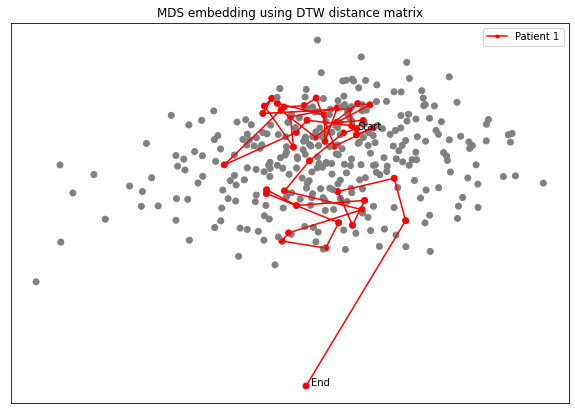

In [107]:
plot_single_trajectory(metric='dtw', color_file=1)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


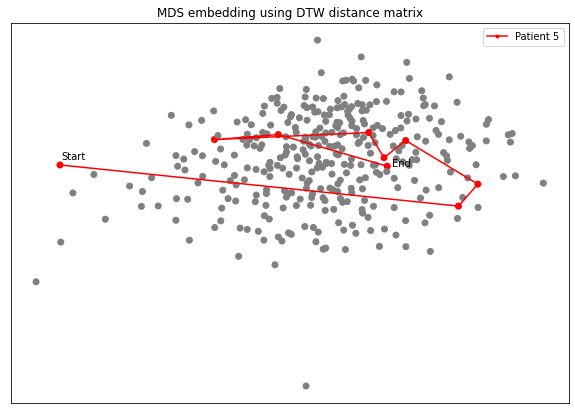

In [108]:
plot_single_trajectory(metric='dtw', color_file=5)

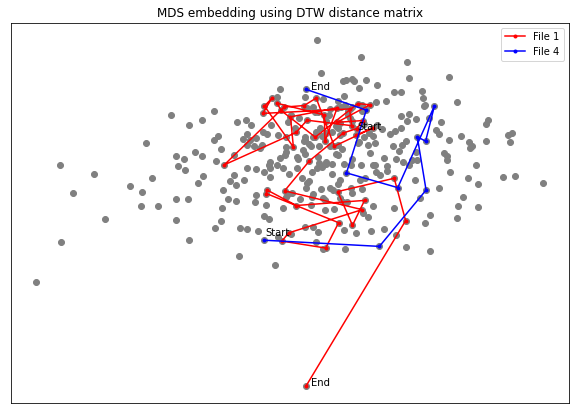

In [44]:
plot_two_trajectories(metric='dtw', color_file=[1,4])

# Plots for paper

In [45]:
file = 1
start_times = []

for md in metadata:
    if int(md[0][-1]) == file:
        start_times.append(md[1]) # get start time
        
df = dfs[file].reset_index()
smoothed_df = smoothed_dfs[file].reset_index()

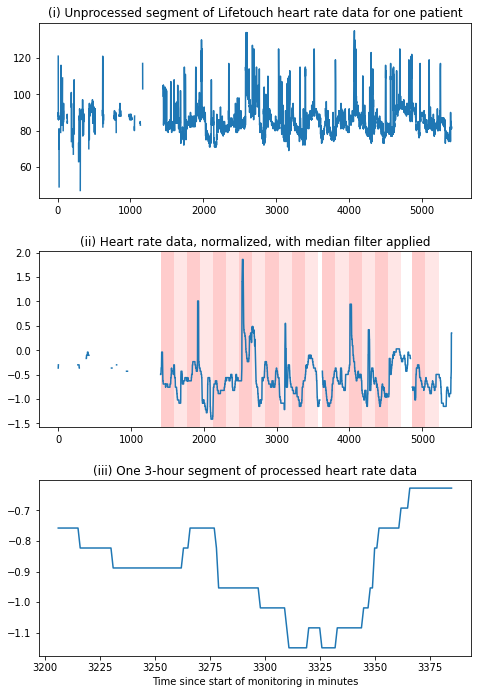

In [46]:
import matplotlib.ticker as plticker

fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(7, 10))

df['Lifetouch Heart Rate'][:start_times[20]+length].plot(
    ax=axs[0])
axs[0].set_title('(i) Unprocessed segment of Lifetouch heart rate data for one patient')
# decrease number of xticks
# loc0 = plticker.MaxNLocator(3) # this locator puts ticks at regular intervals
# axs[0].xaxis.set_major_locator(loc0)
# axs[0].locator_params(nbins=7)

smoothed_df['Lifetouch Heart Rate'][:start_times[20]+length].plot(
    ax=axs[1])
for start in start_times[:20:2]:
    axs[1].axvspan(start, start+length, facecolor='#ffcccc')
for start in start_times[1:20:2]:
    axs[1].axvspan(start, start+length, facecolor='#ffe6e6')
axs[1].set_title('(ii) Heart rate data, normalized, with median filter applied')
# axs[1].xaxis.set_major_locator(loc0)

smoothed_df[start_times[10]:start_times[10]+length]['Lifetouch Heart Rate'].plot(
    ax=axs[2], xlabel="Time since start of monitoring in minutes")
axs[2].set_title(f'(iii) One {length/60:.0f}-hour segment of processed heart rate data')

# decrease number of xticks on 3rd plot
# loc2 = plticker.MultipleLocator(base=50.0) # this locator puts ticks at regular intervals
# axs[2].xaxis.set_major_locator(loc2)


fig.tight_layout(pad=2.0)
plt.savefig('figures/processingsteps.eps', format='eps')
plt.show()

In [47]:
dtw_dist_matrix

array([[ 0.        ,  4.83451859,  7.98004206, ...,  8.24322931,
         9.34492365,  6.46459289],
       [ 4.83451859,  0.        ,  7.79097862, ...,  9.84831671,
        10.81521149,  7.11317213],
       [ 7.98004206,  7.79097862,  0.        , ...,  7.10830783,
         7.19054032,  6.93694868],
       ...,
       [ 8.24322931,  9.84831671,  7.10830783, ...,  0.        ,
         4.42985979,  6.08040348],
       [ 9.34492365, 10.81521149,  7.19054032, ...,  4.42985979,
         0.        ,  4.38562744],
       [ 6.46459289,  7.11317213,  6.93694868, ...,  6.08040348,
         4.38562744,  0.        ]])

In [48]:
squareform(dtw_dist_matrix)

array([ 4.83451859,  7.98004206, 10.19249212, ...,  4.42985979,
        6.08040348,  4.38562744])

In [49]:
# hierarchical clustering using DTW distance matrix
hierarchical = linkage(squareform(dtw_dist_matrix), "average")
hierarchical

array([[ 23.        ,  52.        ,   2.60546447,   2.        ],
       [147.        , 158.        ,   2.76708243,   2.        ],
       [ 85.        , 341.        ,   2.85290842,   3.        ],
       ...,
       [302.        , 677.        ,  32.8110137 , 338.        ],
       [ 43.        , 627.        ,  37.62661852,   3.        ],
       [678.        , 679.        ,  46.24886107, 341.        ]])

In [50]:
hierarchical.max()
np.where(hierarchical == np.amax(hierarchical))

(array([339]), array([1]))

In [51]:
# 2% of epochs is...
hierarchical.shape[0]/25

13.6

In [52]:
metadata

[('File 1', 1406, 1586),
 ('File 1', 1586, 1766),
 ('File 1', 1766, 1946),
 ('File 1', 1946, 2126),
 ('File 1', 2126, 2306),
 ('File 1', 2306, 2486),
 ('File 1', 2486, 2666),
 ('File 1', 2666, 2846),
 ('File 1', 2846, 3026),
 ('File 1', 3026, 3206),
 ('File 1', 3206, 3386),
 ('File 1', 3386, 3566),
 ('File 1', 3628, 3808),
 ('File 1', 3808, 3988),
 ('File 1', 3988, 4168),
 ('File 1', 4168, 4348),
 ('File 1', 4348, 4528),
 ('File 1', 4528, 4708),
 ('File 1', 4863, 5043),
 ('File 1', 5043, 5223),
 ('File 1', 5223, 5403),
 ('File 1', 5403, 5583),
 ('File 1', 5583, 5763),
 ('File 1', 5763, 5943),
 ('File 1', 5943, 6123),
 ('File 1', 6123, 6303),
 ('File 1', 6303, 6483),
 ('File 1', 6532, 6712),
 ('File 1', 6712, 6892),
 ('File 1', 6892, 7072),
 ('File 1', 7072, 7252),
 ('File 1', 7252, 7432),
 ('File 1', 7432, 7612),
 ('File 1', 7612, 7792),
 ('File 1', 7792, 7972),
 ('File 1', 7972, 8152),
 ('File 1', 8152, 8332),
 ('File 1', 8332, 8512),
 ('File 1', 8512, 8692),
 ('File 1', 8692, 8872),


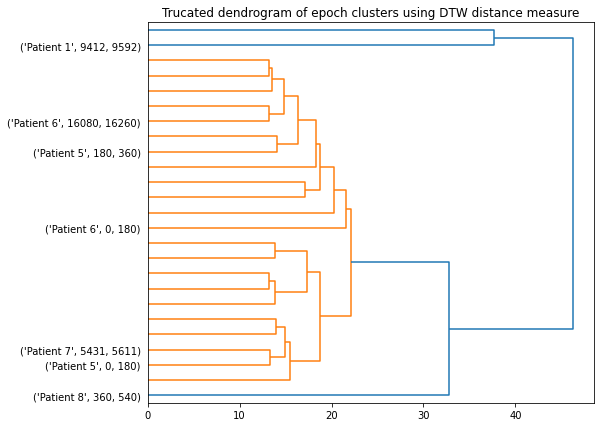

In [53]:
plt.figure(figsize=(8, 7))
dendrogram(
    hierarchical,
    orientation='right',
    truncate_mode='lastp',  # show only the last p merged clusters
    p=25,  # 7 is 2%, some fiddling got 25 clusters shows us 7
    labels=metadata_pts,
    distance_sort='descending',
    show_leaf_counts=False,
    leaf_rotation=0.,
    )
plt.title("Trucated dendrogram of epoch clusters using DTW distance measure")
plt.savefig('figures/al-dendrogram.eps', format='eps', bbox_inches='tight')
plt.show()

[('File 7', 0, 180),
 ('File 9', 360, 540),
 ('File 7', 15360, 15540),
 ('File 7', 12558, 12738),
 ('File 6', 180, 360),
 ('File 8', 360, 540),
 ('File 1', 9412, 9592)]

In [54]:
hierarchical.shape

(340, 4)

In [55]:
hierarchical[:,2].argmax()

339

In [56]:
truncate_p = 50
hierarchical[340-truncate_p:340,0]

array([190., 277., 584., 155., 602., 610., 582., 616., 561., 622., 594.,
       309., 188., 204., 590., 121., 191., 300.,  66., 642., 645., 591.,
       174., 634., 124., 609., 630., 625., 192., 106., 649., 650., 633.,
       639., 107., 659., 660., 656., 665., 626., 662., 646., 668., 670.,
       644., 115., 673., 302.,  43., 678.])

In [57]:
idxs = np.where(hierarchical[340-truncate_p:340,0] <= 339)[0] + 340-truncate_p
idxs

array([290, 291, 293, 301, 302, 303, 305, 306, 307, 308, 312, 314, 318,
       319, 324, 335, 337, 338])

In [58]:
idxs.shape

(18,)

In [59]:
hierarchical[idxs]

array([[190.        , 621.        ,  10.15058656,   4.        ],
       [277.        , 596.        ,  10.22253343,   4.        ],
       [155.        , 604.        ,  10.24512753,   5.        ],
       [309.        , 636.        ,  11.07448498,  55.        ],
       [188.        , 210.        ,  11.12875359,   2.        ],
       [204.        , 599.        ,  11.26676193,   3.        ],
       [121.        , 600.        ,  11.5164637 ,   3.        ],
       [191.        , 635.        ,  11.61282861,  51.        ],
       [300.        , 641.        ,  11.67486012,  20.        ],
       [ 66.        , 201.        ,  11.79889952,   2.        ],
       [174.        , 631.        ,  12.60807691,   5.        ],
       [124.        , 565.        ,  13.0343273 ,   7.        ],
       [192.        , 651.        ,  13.22868218,  67.        ],
       [106.        , 224.        ,  13.30918556,   2.        ],
       [107.        , 653.        ,  14.02712165,   6.        ],
       [115.        , 675

In [60]:
hierarchical[idxs][:,0].astype(int)

array([190, 277, 155, 309, 188, 204, 121, 191, 300,  66, 174, 124, 192,
       106, 107, 115, 302,  43])

In [61]:
len(metadata)

341

In [62]:
top_outliers = [ metadata[i] for i in hierarchical[idxs][:,0].astype(int)]
top_outliers[::-1]

[('File 1', 9412, 9592),
 ('File 9', 360, 540),
 ('File 7', 0, 180),
 ('File 6', 180, 360),
 ('File 6', 0, 180),
 ('File 7', 16080, 16260),
 ('File 7', 1686, 1866),
 ('File 7', 12558, 12738),
 ('File 5', 3946, 4126),
 ('File 9', 0, 180),
 ('File 7', 15900, 16080),
 ('File 7', 1080, 1260),
 ('File 8', 1146, 1326),
 ('File 7', 15360, 15540),
 ('File 9', 2282, 2462),
 ('File 7', 8341, 8521),
 ('File 8', 25606, 25786),
 ('File 7', 15720, 15900)]

In [63]:
top_outliers_cmap_list = np.zeros(len(metadata))
top_outliers_cmap_list[hierarchical[idxs][:,0].astype(int)] = 1
top_outliers_cmap_list

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [64]:
embedding = MDS(n_components=2, dissimilarity='precomputed', random_state=0)
X_dtw_transformed = embedding.fit_transform(dtw_dist_matrix)

Text(0.5, 1.0, 'MDS embedding using DTW distance matrix')

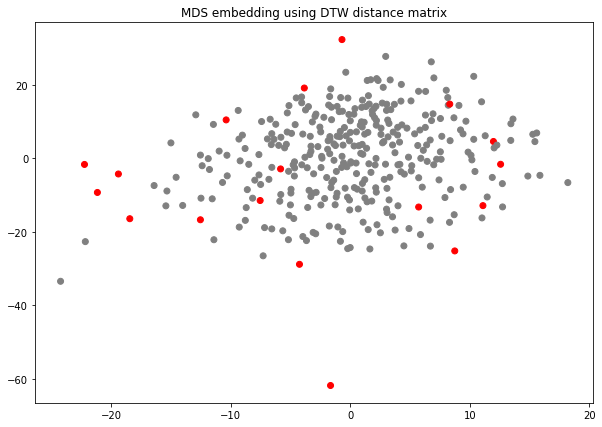

In [65]:
plt.figure(figsize=(10, 7))
# make a color map of fixed colors
cmap = colors.ListedColormap(['grey', 'red'])
plt.scatter(X_dtw_transformed[:,0], X_dtw_transformed[:,1],
           c=top_outliers_cmap_list,
           cmap=cmap)
plt.title('MDS embedding using DTW distance matrix')

In [66]:
file = 1
df = dfs[file].reset_index()
smoothed_df = smoothed_dfs[file].reset_index()

start_times = []
for md in metadata:
    if int(md[0][-1]) == file:
        start_times.append(md[1]) # get start time

In [80]:
def plot_twinx(df, title, label, start_times=None, fixed_yax=False):
    fig, ax1 = plt.subplots(figsize=(10,5))
    if fixed_yax:
        fig.set_size_inches(6,3.5)
    ax1.set_title(title)

    colorlist = ['tab:blue', 'tab:red']
    df['Lifetouch Respiration Rate'][:].plot(ax=ax1, color=colorlist[0])
    ax1.set_xlabel("Time since start of monitoring in minutes")
    ax1.set_ylabel('Respiration Rate', color=colorlist[0])
    ax1.tick_params(axis='y', labelcolor=colorlist[0])

    ax2 = ax1.twinx()
    df['Lifetouch Heart Rate'][:].plot(ax=ax2, color=colorlist[1])
    ax2.set_ylabel('Heart Rate', color=colorlist[1])
    ax2.tick_params(axis='y', labelcolor=colorlist[1])

    if start_times is not None:
        midpoint = int(len(start_times)/2 - 1)

        for start in start_times[::midpoint]:
            ax1.axvspan(start, start+length, facecolor='#ccddff')
    if fixed_yax:
        ax1.set_ylim([-1.5, 6])
        ax2.set_ylim([-1.5, 6])

    plt.savefig(f'figures/{label}.png', format='png')
    plt.show()

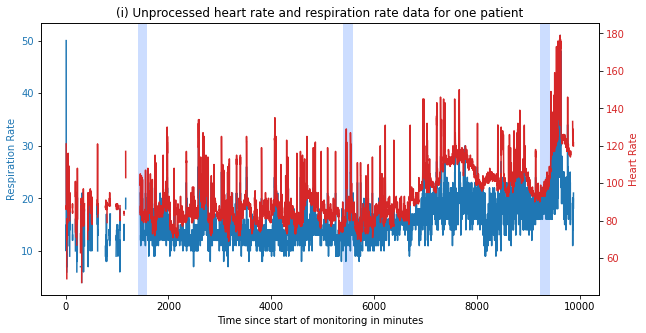

In [68]:
plot_twinx(
    df, 
    title='(i) Unprocessed heart rate and respiration rate data for one patient', 
    label='pt1-full', 
    start_times=start_times
)

In [69]:
print(smoothed_df['Lifetouch Respiration Rate'].min())
print(smoothed_df['Lifetouch Respiration Rate'].max())

-1.4579610818278534
5.69493952409523


In [70]:
print(smoothed_df['Lifetouch Heart Rate'].min())
print(smoothed_df['Lifetouch Heart Rate'].max())

-1.4118498571106437
5.327848818706672


In [71]:
hr_ax = np.linspace(smoothed_df['Lifetouch Heart Rate'].min(), smoothed_df['Lifetouch Heart Rate'].max())
hr_ax

array([-1.41184986, -1.27430499, -1.13676012, -0.99921524, -0.86167037,
       -0.7241255 , -0.58658063, -0.44903576, -0.31149089, -0.17394602,
       -0.03640115,  0.10114372,  0.23868859,  0.37623347,  0.51377834,
        0.65132321,  0.78886808,  0.92641295,  1.06395782,  1.20150269,
        1.33904756,  1.47659243,  1.6141373 ,  1.75168217,  1.88922705,
        2.02677192,  2.16431679,  2.30186166,  2.43940653,  2.5769514 ,
        2.71449627,  2.85204114,  2.98958601,  3.12713088,  3.26467575,
        3.40222063,  3.5397655 ,  3.67731037,  3.81485524,  3.95240011,
        4.08994498,  4.22748985,  4.36503472,  4.50257959,  4.64012446,
        4.77766933,  4.91521421,  5.05275908,  5.19030395,  5.32784882])

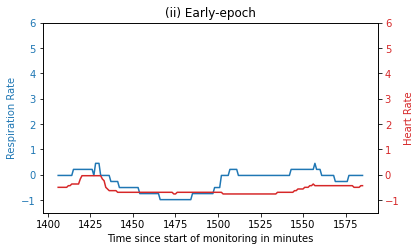

In [72]:
start = start_times[0]

plot_twinx(
    smoothed_df[start:start+length], 
    title='(ii) Early-epoch', 
    label='pt1-start',
    fixed_yax=True
)

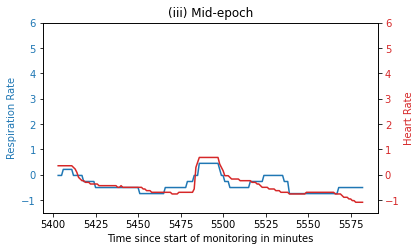

In [73]:
start = start_times[int(len(start_times)/2 - 1)]

plot_twinx(
    smoothed_df[start:start+length], 
    title='(iii) Mid-epoch', 
    label='pt1-mid',
    fixed_yax=True
)

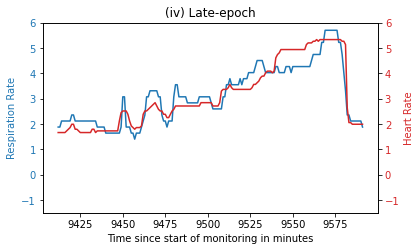

In [74]:
start = start_times[-1]

plot_twinx(
    smoothed_df[start:start+length], 
    title='(iv) Late-epoch', 
    label='pt1-late',
    fixed_yax=True
)

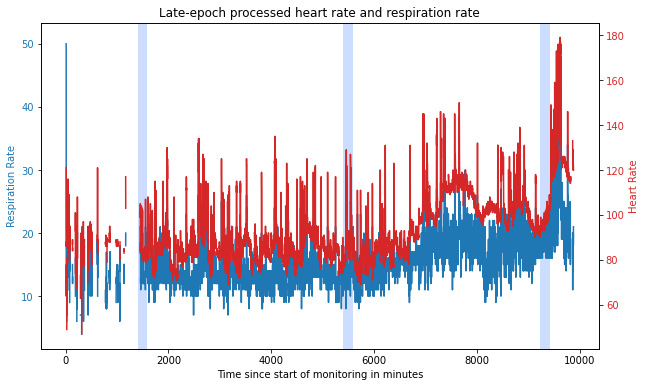

In [75]:
fig, ax1 = plt.subplots(figsize=(10,6))
ax1.set_title('Late-epoch processed heart rate and respiration rate')

colors = ['tab:blue', 'tab:red']
df['Lifetouch Respiration Rate'][:].plot(ax=ax1, color=colors[0])
ax1.set_xlabel("Time since start of monitoring in minutes")
ax1.set_ylabel('Respiration Rate', color=colors[0])
ax1.tick_params(axis='y', labelcolor=colors[0])

ax2 = ax1.twinx()
df['Lifetouch Heart Rate'][:].plot(ax=ax2, color=colors[1])
ax2.set_ylabel('Heart Rate', color=colors[1])
ax2.tick_params(axis='y', labelcolor=colors[1])

midpoint = int(len(start_times)/2 - 1)

for start in start_times[::midpoint]:
    ax1.axvspan(start, start+length, facecolor='#ccddff')

plt.savefig('figures/pt1-end.eps', format='eps')
plt.show()

In [76]:
start_times[-1]

9412

In [77]:
start_times[::197]

[1406]